In [60]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

pbc = pd.read_csv('dataset_prova/cas_sm_pubchem.csv').drop(columns = 'Unnamed: 0')

pbc1 = pbc.pubchem2d[0].replace('', ' ').strip().split(' ')
pbc2 = pbc.pubchem2d[1].replace('', ' ').strip().split(' ')
a = np.array((pbc1,pbc2))

for i in range(2,len(pbc.pubchem2d)):
    try:
        p = pbc.pubchem2d[i].replace('', ' ').strip().split(' ')
        a = np.concatenate((a,[p]))
    except:
        continue

hamming_matrix = squareform(pdist(a, metric = 'hamming'))

In [61]:
hamming_matrix.shape

(2720, 2720)

Per confrontare i cluster che otteniamo con quelli di Tanimoto, non dobbiamo considerare alcuni composti, ossia quelli che non hanno la rappresentazione usando la funzione Fingerprint di rdkit.

Costruisco il dataset dei composti tramite i quali è possibile fare il clustering. Questi composti saranno quelli di cui è possibile avere la distanza di Tanimoto.

In [65]:
from rdkit.Chem import MolFromSmiles
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

l1 = list()
idx_nofinprint = list()
for i in range(len(pbc.smiles)):
    try:
        l1.append(FingerprintMols.FingerprintMol(MolFromSmiles(pbc.smiles[i])))
    except:
        idx_nofinprint.append(i)
        continue

no_finprint = pbc.loc[idx_nofinprint]

temp = pbc.copy().drop(idx_nofinprint).dropna()
print(temp.shape)
temp.reset_index(drop = True).to_csv('dataset_prova/chem_clustering.csv')

(2694, 3)


Nel dataset **chem_clustering.csv** ci sono i composti che possono essere utilizzati per il clustering.

# Clustering (Hamming Distance)

In [2]:
import pandas as pd
import numpy as np

csp = pd.read_csv('dataset_prova/chem_clustering.csv').drop(columns = 'Unnamed: 0')
csp

,cas,smiles,pubchem2d
0,10108-64-2,[Cl-].[Cl-].[Cd++],0000000000000000000000000000000000000110000000...
1,88-30-2,Oc1ccc(c(c1)C(F)(F)F)[N+]([O-])=O,1000000001100010001100011000000000000000000000...
2,1397-94-0,CCCCCC[C@@H]1[C@@H](OC(=O)CC(C)C)[C@H](C)OC(=O...,1111000001111011001111000000000000000000000000...
3,540-72-7,[Na+].[S-]C#N,0000000000000010000000000010000001000000000000...
4,72-43-5,COc1ccc(cc1)C(c2ccc(OC)cc2)C(Cl)(Cl)Cl,1100000001111000001100000000000000000110000000...
...,...,...,...
2689,103-05-9,CC(C)(O)CCc1ccccc1,1110000001110000001000000000000000000000000000...
2690,14008-58-3,CCCCNC(=O)NC(=O)c1cccnc1,1100000001110011001100000000000000000000000000...
2691,52316-55-9,COC(=O)Nc1[nH]c2ccccc2n1.O[P](O)(O)=O,1100000001110011001110000000001000000000000000...
2692,499-83-2,OC(=O)c1cccc(n1)C(O)=O,1000000001100010001110000000000000000000000000...


Costruisco la matrice di distanze basato sul criterio di Hamming.

In [5]:
from scipy.spatial.distance import pdist, squareform

pbc1 = csp.pubchem2d[0].replace('', ' ').strip().split(' ')
pbc2 = csp.pubchem2d[1].replace('', ' ').strip().split(' ')
a = np.array((pbc1,pbc2))

for i in range(2,len(csp.pubchem2d)):
    p = csp.pubchem2d[i].replace('', ' ').strip().split(' ')
    a = np.concatenate((a,[p]))

hamming_matrix = squareform(pdist(a, metric = 'hamming'))
print(hamming_matrix.shape)
hamming_matrix

(2694, 2694)


array([[0.        , 0.13393871, 0.20090806, ..., 0.17139614, 0.15209989,
        0.02837684],
       [0.13393871, 0.        , 0.11464245, ..., 0.14869467, 0.10215664,
        0.13053348],
       [0.20090806, 0.11464245, 0.        , ..., 0.16345062, 0.10329171,
        0.1861521 ],
       ...,
       [0.17139614, 0.14869467, 0.16345062, ..., 0.        , 0.10556186,
        0.16572077],
       [0.15209989, 0.10215664, 0.10329171, ..., 0.10556186, 0.        ,
        0.13734393],
       [0.02837684, 0.13053348, 0.1861521 , ..., 0.16572077, 0.13734393,
        0.        ]])

In [7]:
sum(squareform(hamming_matrix, force = 'to_vector') == 0) # numero di distanza pari a 0

229

Essendo una matrice quadrata e simmetrica di distanze, ogni riga e colonna si riferisce al composto relativo nel dataset *csp* (cas,smiles,pubchem).

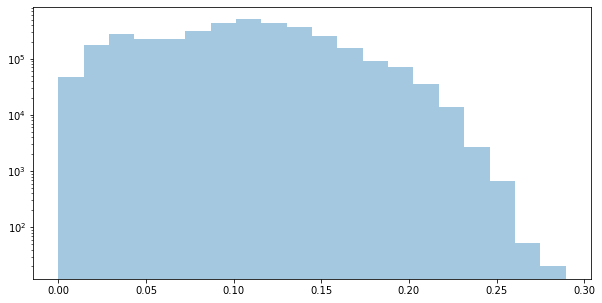

In [69]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize = (10,5))
a = sb.distplot(squareform(hamming_matrix, force='tovector'), kde = False, bins = 20 )
a.set_yscale('log')

Si nota in via preliminare che la scala varia da un minimo di 0 ad un massimo di 0.3. La distanza di Hamming calcolata è relativizzata, quindi oscilla tra 0 e 1. Dove 0 indica l'uguaglianza e 1 la completa diversità.

Iniziamo quindi a osservare se sono presenti cluster.

In [70]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
Z = linkage(squareform(hamming_matrix, force='tovector'), method = 'ward')

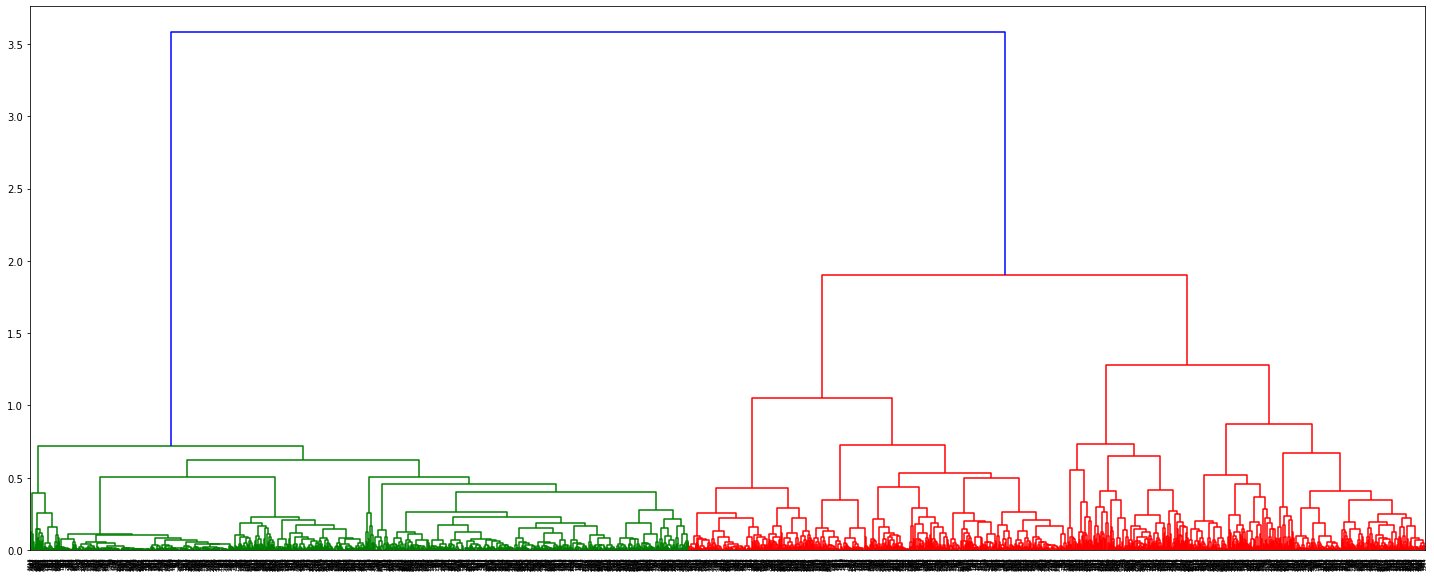

In [71]:
plt.figure(figsize = (25,10))
dnd = dendrogram(Z, show_leaf_counts = True)
plt.show()
# quanti composti ci sono nei cluster principali
# aggiungere linea orizzontale
# tenere dei cluster

Nel grafico sopra si vede come i composti vengono raggruppati insieme, da singleton (cluster con 1 unità) a un unico cluster che li racchiude tutti.

Il dendrogramma può essere tagliato circa all'altezza di *1.5* individuando 3 macro cluster. Abbassando la soglia ovviamente, aumentano il numero di cluster.

Il valore sotto i cluster indicano quante unità fanno parte dei cluster.

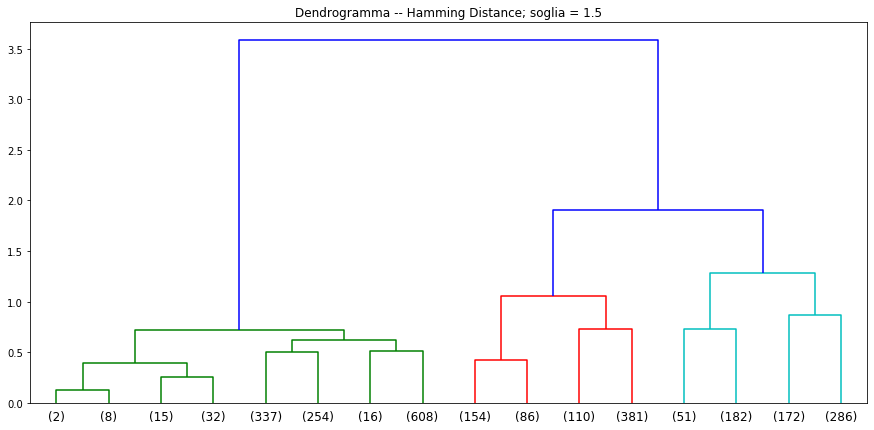

In [72]:
plt.figure(figsize = (15,7))
# il parametro p identifica quanta ramificazione avere dopo il taglio
dnd = dendrogram(Z, truncate_mode = 'level', p = 3, show_leaf_counts = True, color_threshold = 1.5)
plt.title('Dendrogramma -- Hamming Distance; soglia = 1.5')
plt.show()

In [73]:
from scipy.cluster.hierarchy import fcluster
# contiene l'assegnazione dei composti ai cluster
# per avere più cluster bisogna abbassare la soglia
cl = fcluster(Z, t = 1.5, criterion = 'distance')
csp['ham_cluster'] = list(cl)

In [74]:
csp

,cas,smiles,pubchem2d,ham_cluster
0,10108-64-2,[Cl-].[Cl-].[Cd++],0000000000000000000000000000000000000110000000...,1
1,88-30-2,Oc1ccc(c(c1)C(F)(F)F)[N+]([O-])=O,1000000001100010001100011000000000000000000000...,3
2,1397-94-0,CCCCCC[C@@H]1[C@@H](OC(=O)CC(C)C)[C@H](C)OC(=O...,1111000001111011001111000000000000000000000000...,3
3,540-72-7,[Na+].[S-]C#N,0000000000000010000000000010000001000000000000...,1
4,72-43-5,COc1ccc(cc1)C(c2ccc(OC)cc2)C(Cl)(Cl)Cl,1100000001111000001100000000000000000110000000...,2
...,...,...,...,...
2689,103-05-9,CC(C)(O)CCc1ccccc1,1110000001110000001000000000000000000000000000...,2
2690,14008-58-3,CCCCNC(=O)NC(=O)c1cccnc1,1100000001110011001100000000000000000000000000...,3
2691,52316-55-9,COC(=O)Nc1[nH]c2ccccc2n1.O[P](O)(O)=O,1100000001110011001110000000001000000000000000...,3
2692,499-83-2,OC(=O)c1cccc(n1)C(O)=O,1000000001100010001110000000000000000000000000...,3


Nello script pubchem2d c'è anche il biclustering. Le partizioni ottenute sono estremamente simili (Adjusted Rand Index = 0.90).
Lo metto anche qui.

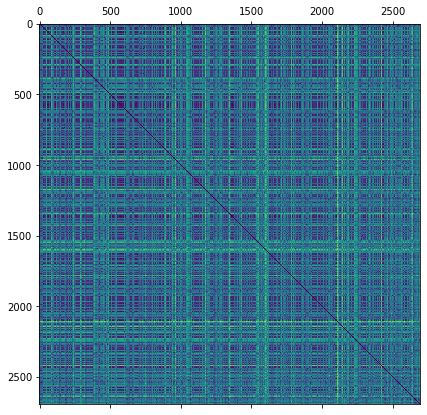

In [75]:
plt.figure(figsize=(7, 7))
plt.matshow(hamming_matrix, fignum = 0)
# viola valori bassi
# celeste valori alti

0.9014220028016549

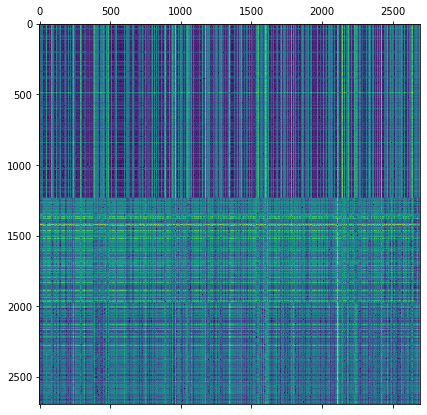

In [77]:
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import adjusted_rand_score

n_clusters = (3,3)

model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(hamming_matrix)

fit_data = hamming_matrix[np.argsort(model.row_labels_)]
plt.figure(figsize=(7, 7))
plt.matshow(fit_data, fignum= 0)

adjusted_rand_score(model.row_labels_ , csp.ham_cluster)

# Clustering (Tanimoto Index)

In [3]:
from rdkit.Chem import MolFromSmiles
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat
from scipy.spatial.distance import pdist, squareform

l1 = list()
idx_nofinprint = list()
for i in range(len(csp.smiles)):
    try:
        l1.append(FingerprintMols.FingerprintMol(MolFromSmiles(csp.smiles[i])))
    except:
        idx_nofinprint.append(i)
        continue

tanimoto_matrix = squareform(GetTanimotoDistMat(l1))
print(tanimoto_matrix.shape)
tanimoto_matrix

(2694, 2694)


array([[0.        , 1.        , 1.        , ..., 0.984375  , 0.890625  ,
        0.74922601],
       [1.        , 0.        , 0.61568627, ..., 0.75      , 0.75      ,
        1.        ],
       [1.        , 0.61568627, 0.        , ..., 0.96875   , 0.74056967,
        0.81712756],
       ...,
       [0.984375  , 0.75      , 0.96875   , ..., 0.        , 0.65625   ,
        0.65625   ],
       [0.890625  , 0.75      , 0.74056967, ..., 0.65625   , 0.        ,
        0.65079365],
       [0.74922601, 1.        , 0.81712756, ..., 0.65625   , 0.65079365,
        0.        ]])

In [4]:
sum(squareform(tanimoto_matrix, force = 'to_vector') == 0) #numero di 0

5230

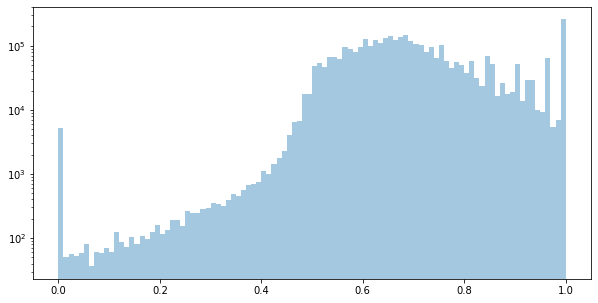

In [68]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize = (10,5))
a = sb.distplot(squareform(tanimoto_matrix, force='tovector'), kde = False, bins = 100 )
a.set_yscale('log')
# La delta in 0 in modo logaritmico a parte...

Ingrandiamo il bin in 0 tramite un logbinning

In [101]:
vec = squareform(tanimoto_matrix, force='tovector')
print(vec.shape)
vec = pd.Series(vec)
print('''Ci sono {} valori pari a 0'''.format(vec.value_counts()[0]))
vec.replace(0, 1e-4, inplace = True)

(3627471,)
Ci sono 5230 valori pari a 0


In [5]:
def logbinning_mod(values, xmin=-1, xmax=-1, n=10, align='center'):
	'''
	Logarithmic binning of values
	'''
	#Parameters
	if(xmin==-1):
	    xmin=values.min()
	if(xmax==-1):
	    xmax=values.max()
	assert(xmin>0 and xmax>xmin)

	#Grandezze derivate
	ymin=np.log(xmin)
	ymax=np.log(xmax+0.001*(xmax-xmin/n))
	delta=np.double(ymax-ymin)/n
	histo_unfair=np.zeros(n)
	nval=len(values)

	for val in values:
	    yi=np.log(val)
	    ibin=int((yi-ymin)/delta)
	    histo_unfair[ibin]+=1

    # Left centered bins
	bins =np.array([np.exp(ymin+ibin*delta) for ibin in range(n+1)]) # Bins centered on the left side

	# Since bins are of variable size, the correct histogram divides by the bin width
	histo=np.array( [histo_unfair[i]/(bins[i+1]-bins[i]) for i in range(n) ])
	density=histo/nval # Normalized histogram

	if align=='center':
		bins = np.array([np.sqrt(bins[ibin]*bins[ibin+1]) for ibin in range(n)]) # Bins centered in the geometric center
	    
	out = np.array([(ibin, bins[ibin], histo[ibin], density[ibin]) for ibin in range(n)])

	return out

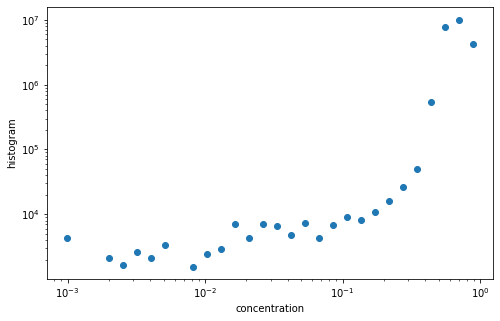

In [106]:
lb=logbinning_mod(vec, n=30)
ax = plt.figure(figsize = (8,5)).add_subplot(1, 1, 1)
ax.plot(lb[:,1],lb[:,2],'o',markersize = 6)
ax.set_ylabel('histogram')
ax.set_xlabel('concentration')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

Ho dovuto togliere i valori che erano pari a 0 altrimenti la funzione "impazziva". 

Per il clustering

In [82]:
Z_tanimoto = linkage(squareform(tanimoto_matrix, force='tovector'), method = 'ward')

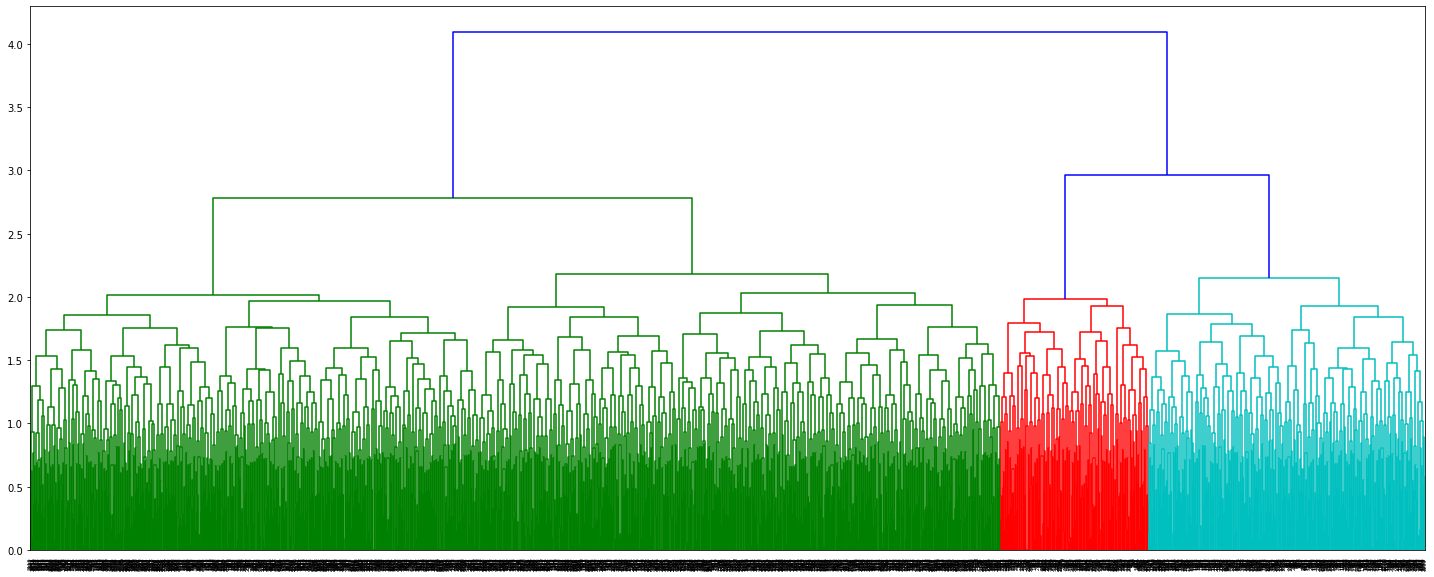

In [83]:
plt.figure(figsize = (25,10))
dnd = dendrogram(Z_tanimoto, show_leaf_counts = True)
plt.show()

WOW... tagliando alla quota di circa 2.5 si ottengono 4 cluster puliti puliti.

Il taglio viene però effettuato poco prima di 3 perchè così si ottengono 3 cluster così da poter confrontare i risultati con l'indice di tanimoto.

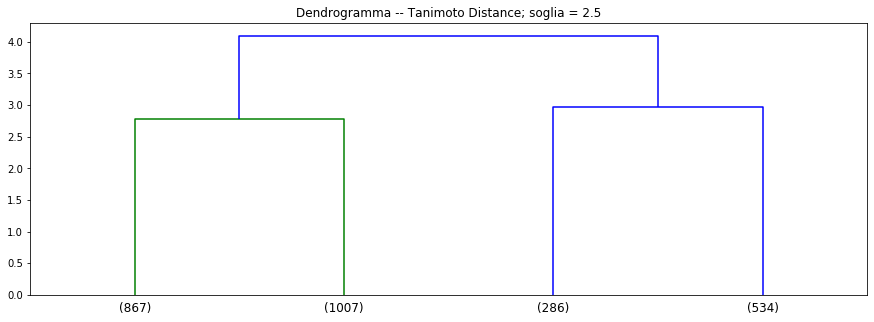

In [100]:
plt.figure(figsize = (15,5))
# il parametro p identifica quanta ramificazione avere dopo il taglio
dnd = dendrogram(Z_tanimoto, truncate_mode = 'level', p = 1, show_leaf_counts = True, color_threshold = 2.9)
plt.title('Dendrogramma -- Tanimoto Distance; soglia = 2.5')
plt.show()

In [105]:
from scipy.cluster.hierarchy import fcluster
# contiene l'assegnazione dei composti ai cluster
# per avere più cluster bisogna abbassare la soglia
cl = fcluster(Z_tanimoto,t = 3, criterion = 'maxclust')
csp['tan_cluster'] = list(cl)

Quanto sono simili i partizionamenti tra hamming e tanimoto?

In [112]:
adjusted_rand_score(csp.ham_cluster, csp.tan_cluster)

-0.00015091793108198523

Non concordano per nulla, i due modelli sono assolutamente diversi.

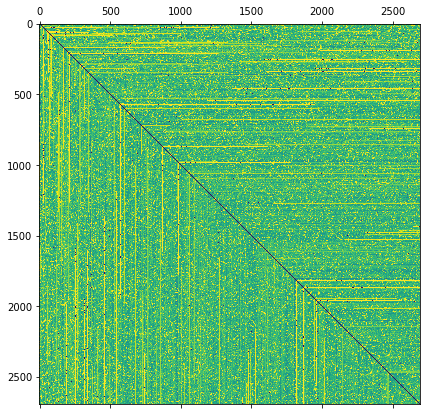

In [116]:
plt.figure(figsize=(7, 7))
plt.matshow(tanimoto_matrix, fignum = 0)
# colore verde valore medio
# colore giallo prossimo a 1

Già dagli istogrammi si notava una certa discordia tra le due distanze. Questo grafico ci indica la profonda differenza: se per l'hamming distance i valori sono bassi o molto bassi, il che indica composti molto vicini, l'indice di tanimoto invece ci dice che i composti sono molto lontani se non assolutamente diversi.

0.04098798296226247

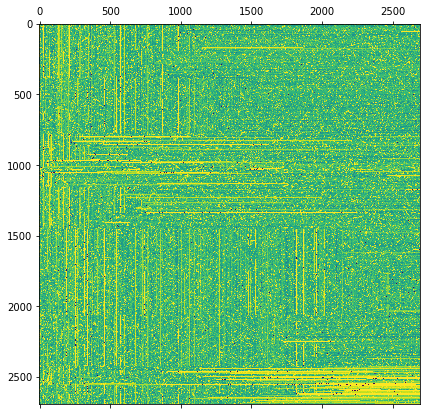

In [118]:
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import adjusted_rand_score

n_clusters = 3

model_tan = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model_tan.fit(tanimoto_matrix)

fit_data_tan = tanimoto_matrix[np.argsort(model_tan.row_labels_)]
plt.figure(figsize=(7, 7))
plt.matshow(fit_data_tan, fignum= 0)

adjusted_rand_score(model_tan.row_labels_ , csp.tan_cluster)

Non saprei quanto può essere utile fare il biclustering su una matrice di distanze...

In [120]:
csp.to_csv('dataset_prova/cluster.csv')

# Clustering (Tanimoto new)

In [1]:
from rdkit.DataStructs.cDataStructs import CreateFromBitString
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat
from scipy.spatial.distance import squareform

import pandas as pd
import numpy as np

csp = pd.read_csv('dataset_prova/chem_clustering.csv').drop(columns = 'Unnamed: 0')
csp


,cas,smiles,pubchem2d
0,10108-64-2,[Cl-].[Cl-].[Cd++],0000000000000000000000000000000000000110000000...
1,88-30-2,Oc1ccc(c(c1)C(F)(F)F)[N+]([O-])=O,1000000001100010001100011000000000000000000000...
2,1397-94-0,CCCCCC[C@@H]1[C@@H](OC(=O)CC(C)C)[C@H](C)OC(=O...,1111000001111011001111000000000000000000000000...
3,540-72-7,[Na+].[S-]C#N,0000000000000010000000000010000001000000000000...
4,72-43-5,COc1ccc(cc1)C(c2ccc(OC)cc2)C(Cl)(Cl)Cl,1100000001111000001100000000000000000110000000...
...,...,...,...
2689,103-05-9,CC(C)(O)CCc1ccccc1,1110000001110000001000000000000000000000000000...
2690,14008-58-3,CCCCNC(=O)NC(=O)c1cccnc1,1100000001110011001100000000000000000000000000...
2691,52316-55-9,COC(=O)Nc1[nH]c2ccccc2n1.O[P](O)(O)=O,1100000001110011001110000000001000000000000000...
2692,499-83-2,OC(=O)c1cccc(n1)C(O)=O,1000000001100010001110000000000000000000000000...


In [2]:
tanimoto_matrix = squareform(GetTanimotoDistMat(csp['pubchem2d'].apply(CreateFromBitString).to_list()))
print(tanimoto_matrix.shape)
tanimoto_matrix

(2694, 2694)


array([[0.        , 1.        , 1.        , ..., 0.968     , 0.96153846,
        0.57055215],
       [1.        , 0.        , 0.77419355, ..., 0.98473282, 0.97478992,
        0.85714286],
       [1.        , 0.77419355, 0.        , ..., 0.98816568, 0.45744681,
        0.83589744],
       ...,
       [0.968     , 0.98473282, 0.98816568, ..., 0.        , 0.9261745 ,
        0.92405063],
       [0.96153846, 0.97478992, 0.45744681, ..., 0.9261745 , 0.        ,
        0.88321168],
       [0.57055215, 0.85714286, 0.83589744, ..., 0.92405063, 0.88321168,
        0.        ]])

In [3]:
sum(squareform(tanimoto_matrix, force = 'to_vector') == 0)

229

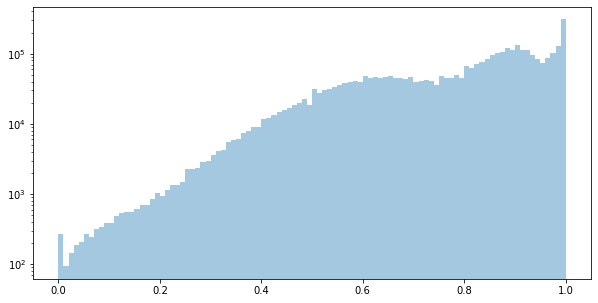

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize = (10,5))
a = sb.distplot(squareform(tanimoto_matrix, force='tovector'), kde = False, bins = 100 )
a.set_yscale('log')

In [23]:
vec = squareform(tanimoto_matrix, force='tovector')
print(vec.shape)
vec = pd.Series(vec)
print('''Ci sono {} valori pari a 0'''.format(vec.value_counts()[0]))
vec.replace(0, 1e-3, inplace = True)

(3627471,)
Ci sono 229 valori pari a 0


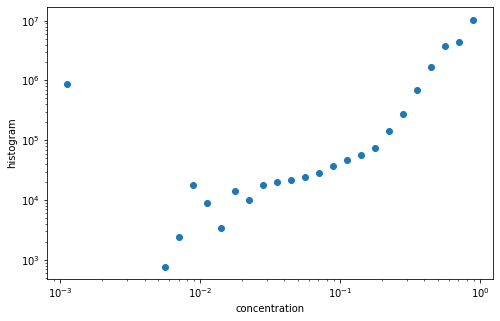

In [24]:
lb=logbinning_mod(vec, n=30)
ax = plt.figure(figsize = (8,5)).add_subplot(1, 1, 1)
ax.plot(lb[:,1],lb[:,2],'o',markersize = 6)
ax.set_ylabel('histogram')
ax.set_xlabel('concentration')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

Z_tanimoto = linkage(squareform(tanimoto_matrix, force='tovector'), method = 'ward')

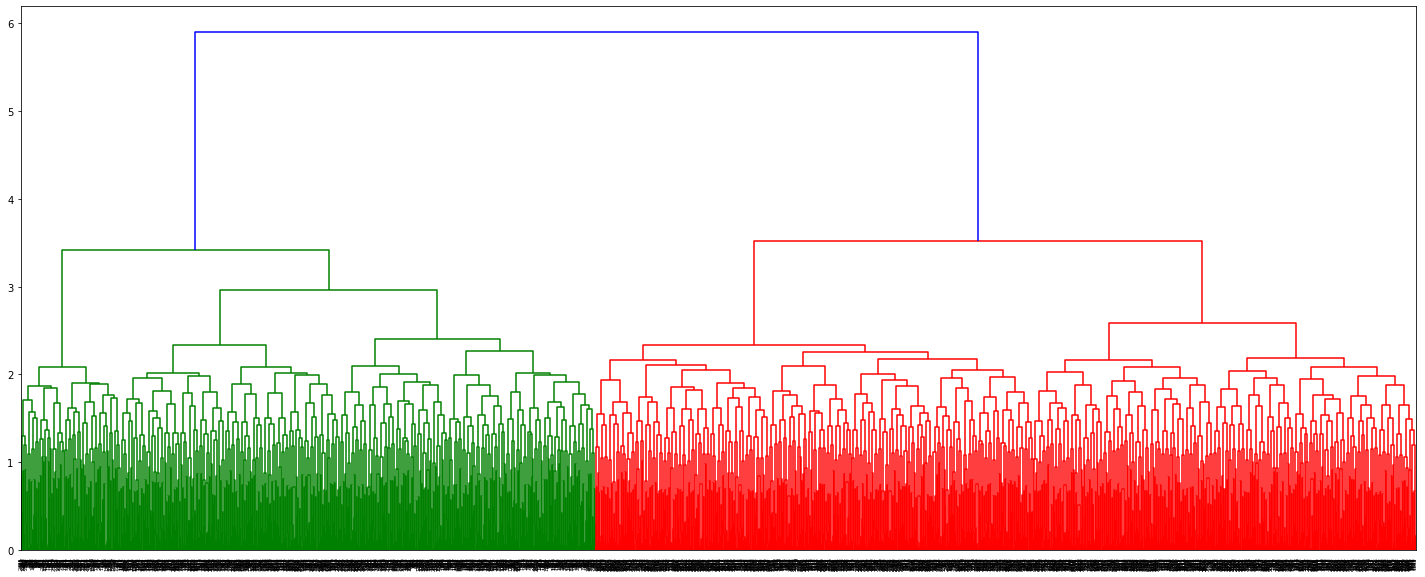

In [7]:
plt.figure(figsize = (25,10))
dnd = dendrogram(Z_tanimoto, show_leaf_counts = True)
plt.show()

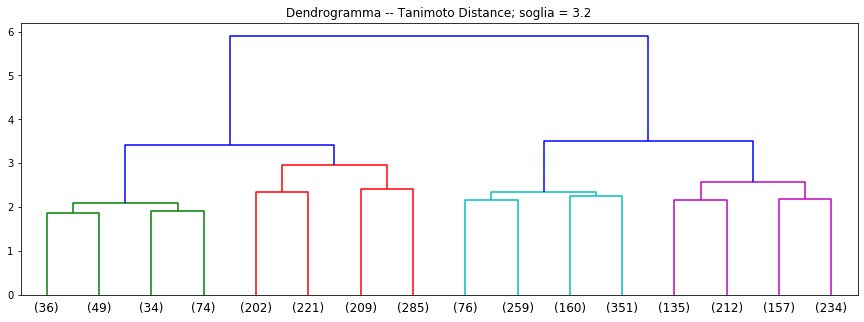

In [16]:
plt.figure(figsize = (15,5))
# il parametro p identifica quanta ramificazione avere dopo il taglio
dnd = dendrogram(Z_tanimoto, truncate_mode = 'level', p = 3, show_leaf_counts = True, color_threshold = 3.2)
plt.title('Dendrogramma -- Tanimoto Distance; soglia = 3.2')
plt.show()

In [4]:
from scipy.cluster.hierarchy import fcluster

cl = fcluster(Z_tanimoto,t = 3.2, criterion = 'maxclust')
csp['tan_cluster'] = list(cl)

In [8]:
cluster = pd.read_csv('dataset_prova/cluster.csv').drop(columns = 'Unnamed: 0')
cluster

,cas,smiles,pubchem2d,ham_cluster,tan_cluster
0,10108-64-2,[Cl-].[Cl-].[Cd++],0000000000000000000000000000000000000110000000...,1,3
1,88-30-2,Oc1ccc(c(c1)C(F)(F)F)[N+]([O-])=O,1000000001100010001100011000000000000000000000...,3,3
2,1397-94-0,CCCCCC[C@@H]1[C@@H](OC(=O)CC(C)C)[C@H](C)OC(=O...,1111000001111011001111000000000000000000000000...,3,3
3,540-72-7,[Na+].[S-]C#N,0000000000000010000000000010000001000000000000...,1,1
4,72-43-5,COc1ccc(cc1)C(c2ccc(OC)cc2)C(Cl)(Cl)Cl,1100000001111000001100000000000000000110000000...,2,2
...,...,...,...,...,...
2689,103-05-9,CC(C)(O)CCc1ccccc1,1110000001110000001000000000000000000000000000...,2,1
2690,14008-58-3,CCCCNC(=O)NC(=O)c1cccnc1,1100000001110011001100000000000000000000000000...,3,1
2691,52316-55-9,COC(=O)Nc1[nH]c2ccccc2n1.O[P](O)(O)=O,1100000001110011001110000000001000000000000000...,3,1
2692,499-83-2,OC(=O)c1cccc(n1)C(O)=O,1000000001100010001110000000000000000000000000...,3,1


In [9]:
cluster.tan_cluster = list(cl)

In [10]:
cluster

,cas,smiles,pubchem2d,ham_cluster,tan_cluster
0,10108-64-2,[Cl-].[Cl-].[Cd++],0000000000000000000000000000000000000110000000...,1,2
1,88-30-2,Oc1ccc(c(c1)C(F)(F)F)[N+]([O-])=O,1000000001100010001100011000000000000000000000...,3,1
2,1397-94-0,CCCCCC[C@@H]1[C@@H](OC(=O)CC(C)C)[C@H](C)OC(=O...,1111000001111011001111000000000000000000000000...,3,2
3,540-72-7,[Na+].[S-]C#N,0000000000000010000000000010000001000000000000...,1,2
4,72-43-5,COc1ccc(cc1)C(c2ccc(OC)cc2)C(Cl)(Cl)Cl,1100000001111000001100000000000000000110000000...,2,1
...,...,...,...,...,...
2689,103-05-9,CC(C)(O)CCc1ccccc1,1110000001110000001000000000000000000000000000...,2,2
2690,14008-58-3,CCCCNC(=O)NC(=O)c1cccnc1,1100000001110011001100000000000000000000000000...,3,1
2691,52316-55-9,COC(=O)Nc1[nH]c2ccccc2n1.O[P](O)(O)=O,1100000001110011001110000000001000000000000000...,3,1
2692,499-83-2,OC(=O)c1cccc(n1)C(O)=O,1000000001100010001110000000000000000000000000...,3,1


In [11]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(cluster.ham_cluster, cluster.tan_cluster)

-0.0006473632400319857

In [12]:
cluster.to_csv('dataset_prova/cluster.csv')